# Feature Identification and Calculation

In the [previous notebook](01_Trimer_Visualisation.ipynb) we visualised the configuration
using the colour to encode the orientation of each molecule.
This approach resulting in a clear visual distinction between
the orientational ordering of the crystal structures
and the disorder of the liquid phase.
Here we are looking at finding a series of *features* which
are able to separate separate the different local configurations.

For this machine learning task for each molecule we want
a series of properties, known in Machine Learning as *features*.
The way of thinking about features is
they define an N dimensional feature space
in which each point is mapped.
The machine learning is then about finding
the surfaces which separate groups of points in feature space.

The engineering of the feature space is
the most important part of any machine learning project.
A simple algorithm with a well designed feature space
will outperform a complex algorithm with a poor feature space.
The feature space is highly specific to the dataset being studied
and is where your domain specific knowledge is most useful.
Having a strong understanding of the system being studied
provides an excellent starting point for developing features,
which was why we started by visualising each of the configurations.

This notebook investigates the calculation of a variety of features
and how much they can separate the different classes.

## Environment Setup

This imports some functions from [sdanalysis](https://github.com/malramsay64/statdyn-analysis)
a package I have written for the analysis of trajectories.
These functions are used to calculate
the orientations of each of the nearest neighbours relative to the orientation of the molecule
and the distance of each of the nearest neighbours from the molecule.

Additionally I am importing some utility functions from the project,
which allow for the reading of files
and the manual classification of each molecule.

In [111]:
from sdanalysis.order import relative_orientations, relative_distances
import numpy as np

# Ignore all warnings which are generated
import warnings
warnings.filterwarnings('ignore')

# Import project source files
import sys
sys.path.append("../src")
from trimer import classify_mols, read_files

This reads configurations for each of the crystal structures
into the variable `snaps`.
These are the configurations we are going to be using throughout
the rest of this notebook.

In [112]:
crystals = ["p2", "p2gg", "pg"]
snaps = read_files(
    pressure=1.00,
    temperature=0.40,
    crystals=crystals
)

## Manual Classification

To know if the features are capturing the differences of interest,
that is between the crystal structures and the liquid,
we need a source of 'truth'.
The configurations we are using have been constructed,
melting the region which is now liquid,
while the crystal region was prevented from moving.
This means I can classify the molecules in these configurations
as liquid or crystalline based on the position,
which is what the `classify_mols` function is doing.

Since the `snaps` variable is a list,
I am using a list comprehension to act on each configuration separately
before concatenating the three configurations into a single array of classes.

In [113]:
classes = np.concatenate(
    [
        classify_mols(snap, crys)
        for snap, crys in zip(snaps, crystals)
    ]
)

The array `classes` is comprised of integer values

- `0` represents the liquid state
- `1` represents the p2 crystal
- `2` represents the p2gg crystal
- `3` represents the pg crystal
- `4` is molecules on the interface, which I will exclude from the analysis.

The molecules on the interface of the liquid and crystal regions
are excluded from this analysis since their state is not well defined,
with typical crystals having a gradient from the crystal to liquid state.

## Relative Orientation

The main visual feature distinguishing the liquid from the crystal
in the previous notebook was the orientation of the neighbouring molecules.
The crystal was highly ordered while the liquid was random.
It makes sense then to use this as some of the features.

The way I am doing this is to use the orientation of the six nearest neighbours,
with a threshold distance for being a neighbour.
Six neighbours was chosen as the expected number for a two dimensional crystal.
The nearest neighbours are returned in order of distance
so the relative orientation of the molecules retains this ordering.
Molecules which don't have six nearest neighbours
have an orientation of 0 for any missing neighbours.


In [114]:
orientations = np.concatenate(
    [
        relative_orientations(
            snap.box,
            snap.position,
            snap.orientation,
            max_neighbours=6
        )
        for snap in snaps
    ]
)

To create our dataset `X_o` 
we only want molecules which are not at the interface
which are those with a value less than 4.
The mask is then applied to the orientations calculated above
and the classes calculated previously.

In [115]:
mask = classes < 4
X_o = orientations[mask]
y = classes[mask]

### Visualisation

With the relative orientations calculated
we want to know whether they are effective at
separating the different crystal structures.
Since it is not possible to visualise 
the six dimensional space each point resides in,
we first have to reduce the dimensionality of the data.
The approach we are using is a Principal Components Analysis (PCA),
which identifies the combination of features responsible for the most variation.

We are going to use the [Scikit-Learn](http://scikit-learn.org/stable/index.html) library
for this analysis since it has all the features we require,
it is well documented and is easy to use.

In [116]:
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt

The standard PCA algorithm is a Singular Value Decomposition (SVD),
a matrix operation which identifies a linear combination of features 
to give the largest variance.

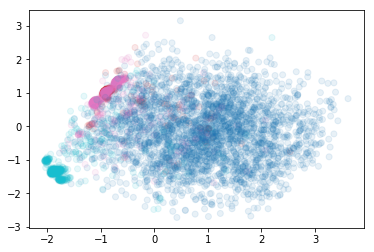

In [117]:
pca = PCA(n_components=2)
X_r = pca.fit_transform(X_o)
plt.scatter(X_r[:, 0], X_r[:, 1], alpha=.1, c=y, cmap='tab10');

In the above image we can see two high density clusters,
in cyan and magenta which would be two of the crystals.
The blue, which is scattered across the space
is quite clearly the liquid state.
From this there is not a lot of separation between the different states,
with the liquid occupying the entire space.

An alternate approach to the dimensionality reduction 
is to use a non-linear combination of feature space.
This effectively makes the changes in some regions 
more important than changes in other regions.
The `KernelPCA` class in Scikit-learn allows for the choice of 'kernel',
where a kernel is a way of performing this non-linear combination of variables.
The kernel I have chosen to use is the [Radial Basis Function (RBF)](http://scikit-learn.org/stable/modules/metrics.html#rbf-kernel).


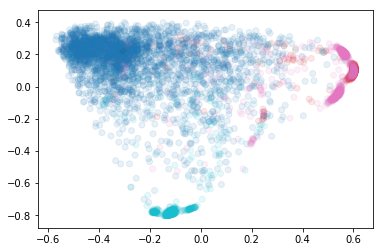

In [118]:
kpca = KernelPCA(n_components=2, kernel='rbf')
X_r = kpca.fit_transform(X_o)
plt.scatter(X_r[:, 0], X_r[:, 1], alpha=.1, c=y, cmap='tab10');

In the image above we can see that by using the RBF kernel
the liquid configurations are all bunched in the top left of the figure,
with a big separation to the cyan and magenta crystal regions.
This separation is really promising for using these features 
for the identification of these structures.
Looking closely, below the magenta region is a red region which will be the third crystal.
This lets us know that to distinguish these crystals 
we need more than two dimensions.

## Using additional features

The figures above show that there is little separation between
the p2 and p2gg crystals in the main two dimensions.
While it is possible the difference is present in other dimensions,
another explanation is that there are not enough information
in the features that are present.
Is it possible to add additional features
which enhance the separation of the different structures?

### Relative distances

The relative distances is another feature which could provide useful information.

In [119]:
distances = np.concatenate(
    [
        relative_distances(snap.box, snap.position, max_neighbours=6)
        for snap in snaps
    ]
)
distances[np.isnan(distances)] = 0
combined = np.concatenate((orientations, distances), axis=1)

In [120]:
mask = classes < 4
X_od = combined[mask]
y = classes[mask]

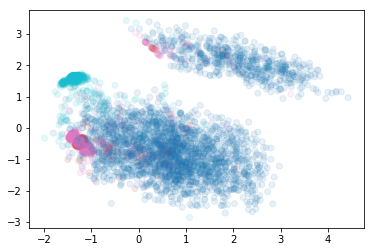

In [121]:
pca = PCA(n_components=2)
X_rd = pca.fit_transform(X_od)
plt.scatter(X_rd[:, 0], X_rd[:, 1], alpha=.1, c=y, cmap='tab10');

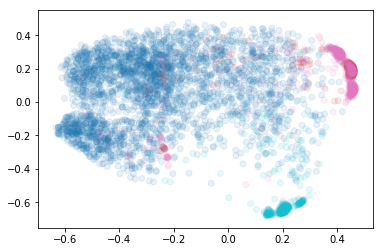

In [122]:
kpca = KernelPCA(n_components=2, kernel='rbf')
X_rd = kpca.fit_transform(X_od)
plt.scatter(X_rd[:, 0], X_rd[:, 1], alpha=.1, c=y, cmap='tab10');